# 1. 导入python库

In [2]:
import pandas as pd
import numpy as np
import os

%matplotlib inline
from matplotlib import pyplot as plt


from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

from sklearn.metrics import confusion_matrix, roc_curve, auc, recall_score, precision_score, f1_score
from tensorflow.keras.callbacks import EarlyStopping


# 2. 参数设置

In [3]:
daily_back=20

batch_size=32
epochs=100
patience=15

LSTM_num=100
dense_num=20

pop_size = 1
max_iter = 2

mix_file='daily_data.xlsx'
first_columns='search_index'


total_day=2307 #根据查看数据表，得到数值
train_num=1846
test_num=total_day-train_num

# 3. 读取原始数据

In [4]:
new_dir='/Users/ccmac/Desktop/完成SCI数据'


daily_df=pd.read_excel(os.path.join(new_dir,mix_file))
fif_df=pd.read_excel(os.path.join(new_dir,'fif_data.xlsx'))
target_df=pd.read_excel(os.path.join(new_dir,'target.xlsx'))


# 4. 标准化

## 4.1 历史数据标准化函数norm

In [5]:
def norm(df):
    x=df.copy()
    open_mean_value = df['open'].mean(axis=0)
    high_mean_value = df['high'].mean(axis=0)
    low_mean_value = df['low'].mean()
    close_mean_value = df['close'].mean()
    volumerate_mean_value = df['volume_rate'].mean()

    open_std_value = df['open'].std()
    high_std_value = df['high'].std()
    low_std_value = df['low'].std()
    close_std_value = df['close'].std()
    volumerate_std_value = df['volume_rate'].std()

    x['open']=(df['open']-open_mean_value)/open_std_value
    x['high'] = (df['high'] - high_mean_value) / high_std_value
    x['low'] =  (df['low'] - low_mean_value) / low_std_value
    x['close'] =  (df['close'] - close_mean_value) / close_std_value
    x['volume_rate'] = (df['volume_rate'] - volumerate_mean_value) / volumerate_std_value
    df=x
    return df

# 5. 数据切分训练集与测试集

## 5.1 数据切分函数

In [6]:
def split_data(train_num=train_num):
    daily_train_df=daily_df.loc[daily_df.index<train_num]
    daily_test_df=daily_df.loc[daily_df.index>=train_num]
    fif_train_df=fif_df.loc[fif_df.index<16*train_num]
    fif_test_df=fif_df.loc[fif_df.index>=16*train_num]


    target_train_df=target_df.loc[target_df.index<train_num]
    target_test_df=target_df.loc[target_df.index>=train_num]

    daily_train_df=norm(daily_train_df)
    daily_test_df=norm(daily_test_df)
    fif_train_df=norm(fif_train_df)
    fif_test_df=norm(fif_test_df)



    return {'daily_train_df':daily_train_df,
            'daily_test_df':daily_test_df,
            'fif_train_df':fif_train_df,
            'fif_test_df':fif_test_df,
            'target_train_df':target_train_df,
            'target_test_df':target_test_df,
    
            }

## 5.2 进行数据切分

In [7]:
daily_norm_train_df=split_data()['daily_train_df']
print('日频训练切分：',daily_norm_train_df.shape)
daily_norm_test_df=split_data()['daily_test_df']
print('日频测试切分：',daily_norm_test_df.shape)
fif_norm_train_df=split_data()['fif_train_df']
print('十五分钟频训练切分：',fif_norm_train_df.shape)
fif_norm_test_df=split_data()['fif_test_df']
print('十五分钟频测试切分：',fif_norm_test_df.shape)
target_norm_train_df=split_data()['target_train_df']
print('训练目标切分：',target_norm_train_df.shape)
target_norm_test_df=split_data()['target_test_df']
print('测试目标切分：',target_norm_test_df.shape)


日频训练切分： (1846, 8)
日频测试切分： (461, 8)
十五分钟频训练切分： (29536, 6)
十五分钟频测试切分： (7552, 6)
训练目标切分： (1846, 2)
测试目标切分： (472, 2)


# 6. 数据转化为神经网络输入格式

## 6.1 建立转化类（返回多个字典）

In [8]:
class Data_maker:
    def __init__(self,train_num,test_num,fif_back,daily_back):
        self.train_num=train_num
        self.test_num=test_num
        self.fif_back=fif_back
        self.daily_back=daily_back
       


    def daily_train_data(self,data):
        while True:
            rows = list(range(self.train_num - self.daily_back)) #总共1650个数据，由于扣除前面20个数据，所以为1630
            ### 先构造空（预测日长度*日后移）array
            samples = np.zeros((len(rows),
                                 self.daily_back,
                                 5))
            print(samples.shape)
            for j in rows:
                ### 每一个填入用于预测一天的开盘价到波动率矩阵
                samples[j] = data.loc[
                                  (data.index >= j) & (data.index < self.daily_back + j),
                                  'open':'volume_rate']
            print(data.index)
            print('日频训练array：',samples.shape)
            return samples
    def fif_train_data(self,data):
        while True:
            rows = list(range(self.train_num - self.daily_back))
            samples = np.zeros((len(rows),
                                 self.fif_back,
                                 5))
            for j in rows:

                samples[j] = data.loc[
                              (data.index >= j * self.fif_back ) & (data.index < (j+1) * self.fif_back),
                              'open':]
            print('十五分钟训练array：',samples.shape)
            return samples

   

    def daily_test_data(self,data):
        while True:
            rows = list(range(self.test_num - self.daily_back))
            print(self.test_num,self.daily_back)
            print(rows)
            samples = np.zeros((len(rows),
                                self.daily_back,
                                 5))
            for j in rows:


                samples[j] = data.loc[
                                  (data.index >= self.train_num+j) & (data.index < self.train_num+self.daily_back + j),
                                  'open':'volume_rate']
            print('日测试array：',samples.shape)
            print('试一试index', data.index,'train_num',self.train_num)
            return samples


   
    def fif_test_data(self,data):
        while True:
            rows = list(range(self.test_num - self.daily_back))
            samples = np.zeros((len(rows),
                                self.fif_back,
                                 5))
            for j in rows:


                samples[j] = data.loc[
                                 (data.index >= 16*self.train_num+(j) * self.fif_back) & (data.index < 16*self.train_num+(j+1) * self.fif_back),
                                 'open':]
            print('十五分钟测试array：',samples.shape)
            return samples
    def target_train_data(self,data):
        while True:
            rows = list(range(self.train_num-self.daily_back))
            targets = np.zeros((len(rows),))
            for j in rows:


                targets[j] = data.loc[data.index == j, 'target'].iloc[0] #根据提示，添加了.iloc[0]
            print('训练标签array',targets.shape)
            return targets
    def target_test_data(self,data):
        while True:
            rows = list(range(self.test_num-self.daily_back))
            targets = np.zeros((len(rows),))
            for j in rows:


                targets[j] = data.loc[data.index == self.train_num+j, 'target'].iloc[0] ##出问题：应该是。而不是***：data.index == self.train_num+j
            print(targets.shape)
            return targets

## 6.2 设置类方法里的参数，赋值给origin_data_maker，仍然是一个class类

In [9]:
origin_data_maker=Data_maker(train_num=train_num,test_num=test_num,fif_back=16,daily_back=20)

# 6.3 调用类中的方法,处理原始数据

In [10]:
DM = origin_data_maker

daily_train_prepared = DM.daily_train_data(daily_norm_train_df)
daily_test_prepared = DM.daily_test_data(daily_norm_test_df)

fif_train_prepared = DM.fif_train_data(fif_norm_train_df)
fif_test_prepared = DM.fif_test_data(fif_norm_test_df)

target_train_prepared = DM.target_train_data(target_norm_train_df)
target_test_prepared = DM.target_test_data(target_norm_test_df)


(1826, 20, 5)
Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
       ...
       1836, 1837, 1838, 1839, 1840, 1841, 1842, 1843, 1844, 1845],
      dtype='int64', length=1846)
日频训练array： (1826, 20, 5)
461 20
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176

# 7. 神经网络模型训练

## 7.1 模型建立 

In [11]:
def my_model(daily_back, LSTM_num, dense_num):

    # 日频输入
    daily_input = Input(shape=(daily_back, 5), dtype='float32', name='daily_input')
    Conv1D_daily = layers.Conv1D(16, 1, strides=1)(daily_input)
    LSTM_daily = layers.LSTM(LSTM_num)(Conv1D_daily)
    
    # 合并与全连接
  
    alloy = layers.Dense(dense_num, activation='relu')(LSTM_daily)
    dropout = layers.Dropout(0.2)(alloy)
    output = layers.Dense(1, activation='sigmoid')(dropout)
    
    model = Model(daily_input, output)
    model.compile(optimizer=Adam(learning_rate=0.001), 
                  loss='binary_crossentropy', 
                  metrics=['acc'])
    return model

## 创建早停机制

In [12]:
# 创建早停回调
early_stopping = EarlyStopping(
    monitor='val_loss',    # 监控验证集损失
    patience=patience,           # 如果连续10个epoch验证集损失没有改善，则停止训练
    restore_best_weights=True  # 恢复验证集损失最低时的模型权重
)


In [13]:
## 定义适应函数

In [14]:
import numpy as np

def fitness_function(params):
    LSTM_num = int(params[0])
    dense_num = int(params[1])
    


    
    model = my_model(daily_back=daily_back,  # 替换为实际daily_back值
                     LSTM_num=LSTM_num,
                     dense_num=dense_num,
                     )
    
    history = model.fit(x=daily_train_prepared,y=target_train_prepared,batch_size=batch_size,
                validation_split=0.25,epochs=epochs,callbacks=[early_stopping])
    return history.history['val_loss'][-1]  # 返回验证损失（越小越好）

In [15]:
# 实现麻雀算法

In [16]:
def sparrow(pop_size, max_iter, dim, lower_bounds, upper_bounds, fitness_func):
    pop = np.random.uniform(low=lower_bounds, high=upper_bounds, size=(pop_size, dim))
    fitness = np.array([fitness_func(ind) for ind in pop])
    best_idx = np.argmin(fitness)
    best_sol = pop[best_idx].copy()
    best_fit = fitness[best_idx]

    for t in range(max_iter):
        # 排序
        sorted_idx = np.argsort(fitness)
        pop = pop[sorted_idx]
        fitness = fitness[sorted_idx]

        # 发现者策略
        for i in range(int(pop_size * 0.2)):
            if np.random.rand() < 0.8:
                pop[i] *= np.exp(-i / (np.random.rand() * max_iter))
            else:
                pop[i] += np.random.normal(0, 1)
            
            # 每次更新后立即检查边界
            pop[i] = np.clip(pop[i], lower_bounds, upper_bounds)

        # 跟随者策略 - 改进矩阵计算
        for i in range(int(pop_size * 0.2), pop_size):
            if i > pop_size / 2:
                pop[i] = np.random.normal(0, 1) * np.exp((pop[-1] - pop[i]) / (i ** 2))
            else:
                # 简化矩阵计算，避免奇异矩阵问题
                A = np.random.choice([-1, 1], size=dim)
                pop[i] = pop[0] + A * (pop[0] - pop[i])
            
            # 每次更新后立即检查边界
            pop[i] = np.clip(pop[i], lower_bounds, upper_bounds)

        # 警戒者策略
        for i in range(pop_size):
            if fitness[i] > best_fit:
                pop[i] = best_sol + np.random.normal(0, 1)
                # 立即检查边界
                pop[i] = np.clip(pop[i], lower_bounds, upper_bounds)

        # 更新最佳解
        fitness = np.array([fitness_func(ind) for ind in pop])
        current_best_idx = np.argmin(fitness)
        if fitness[current_best_idx] < best_fit:
            best_fit = fitness[current_best_idx]
            best_sol = pop[current_best_idx].copy()

    return best_sol, best_fit

In [17]:
# 运行优化并训练最终模型

In [18]:
# 超参数范围（LSTM_num, dense_num）
lower_bounds = [64, 16]
upper_bounds = [256, 64]
pop_size = pop_size
max_iter = max_iter

best_params, best_fitness =sparrow(pop_size, max_iter, 2, lower_bounds, upper_bounds, fitness_function)

print(f"最佳参数：LSTM_num={int(best_params[0])}, dense_num={int(best_params[1])}")
print(f"最佳验证准确率：{best_fitness}")


# 用最佳参数训练最终模型
final_model = my_model(daily_back=daily_back,  # 替换为实际值
                       LSTM_num=int(best_params[0]),
                       dense_num=int(best_params[1]),
                       )
final_model.fit(x=daily_train_prepared,y=target_train_prepared,batch_size=batch_size,
                validation_split=0.25,epochs=epochs,callbacks=[early_stopping])

Epoch 1/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - acc: 0.5641 - loss: 0.6915 - val_acc: 0.4989 - val_loss: 0.7173
Epoch 2/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - acc: 0.5202 - loss: 0.7041 - val_acc: 0.5055 - val_loss: 0.6974
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - acc: 0.5669 - loss: 0.6813 - val_acc: 0.4967 - val_loss: 0.6947
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - acc: 0.5189 - loss: 0.6925 - val_acc: 0.5033 - val_loss: 0.7005
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - acc: 0.5466 - loss: 0.6854 - val_acc: 0.5011 - val_loss: 0.6966
Epoch 6/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - acc: 0.5514 - loss: 0.6913 - val_acc: 0.5033 - val_loss: 0.6961
Epoch 7/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - acc: 0.5478 - loss: 0.6861 - val_acc: 0.4989 - val_loss: 0.7082
Epoch 8/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - acc: 0.5548 - loss: 0.6879 - val_acc: 0.4967 - val_loss: 0.7041
Epoch 9/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - ac

## 7.3 添加输出模型参数的代码块

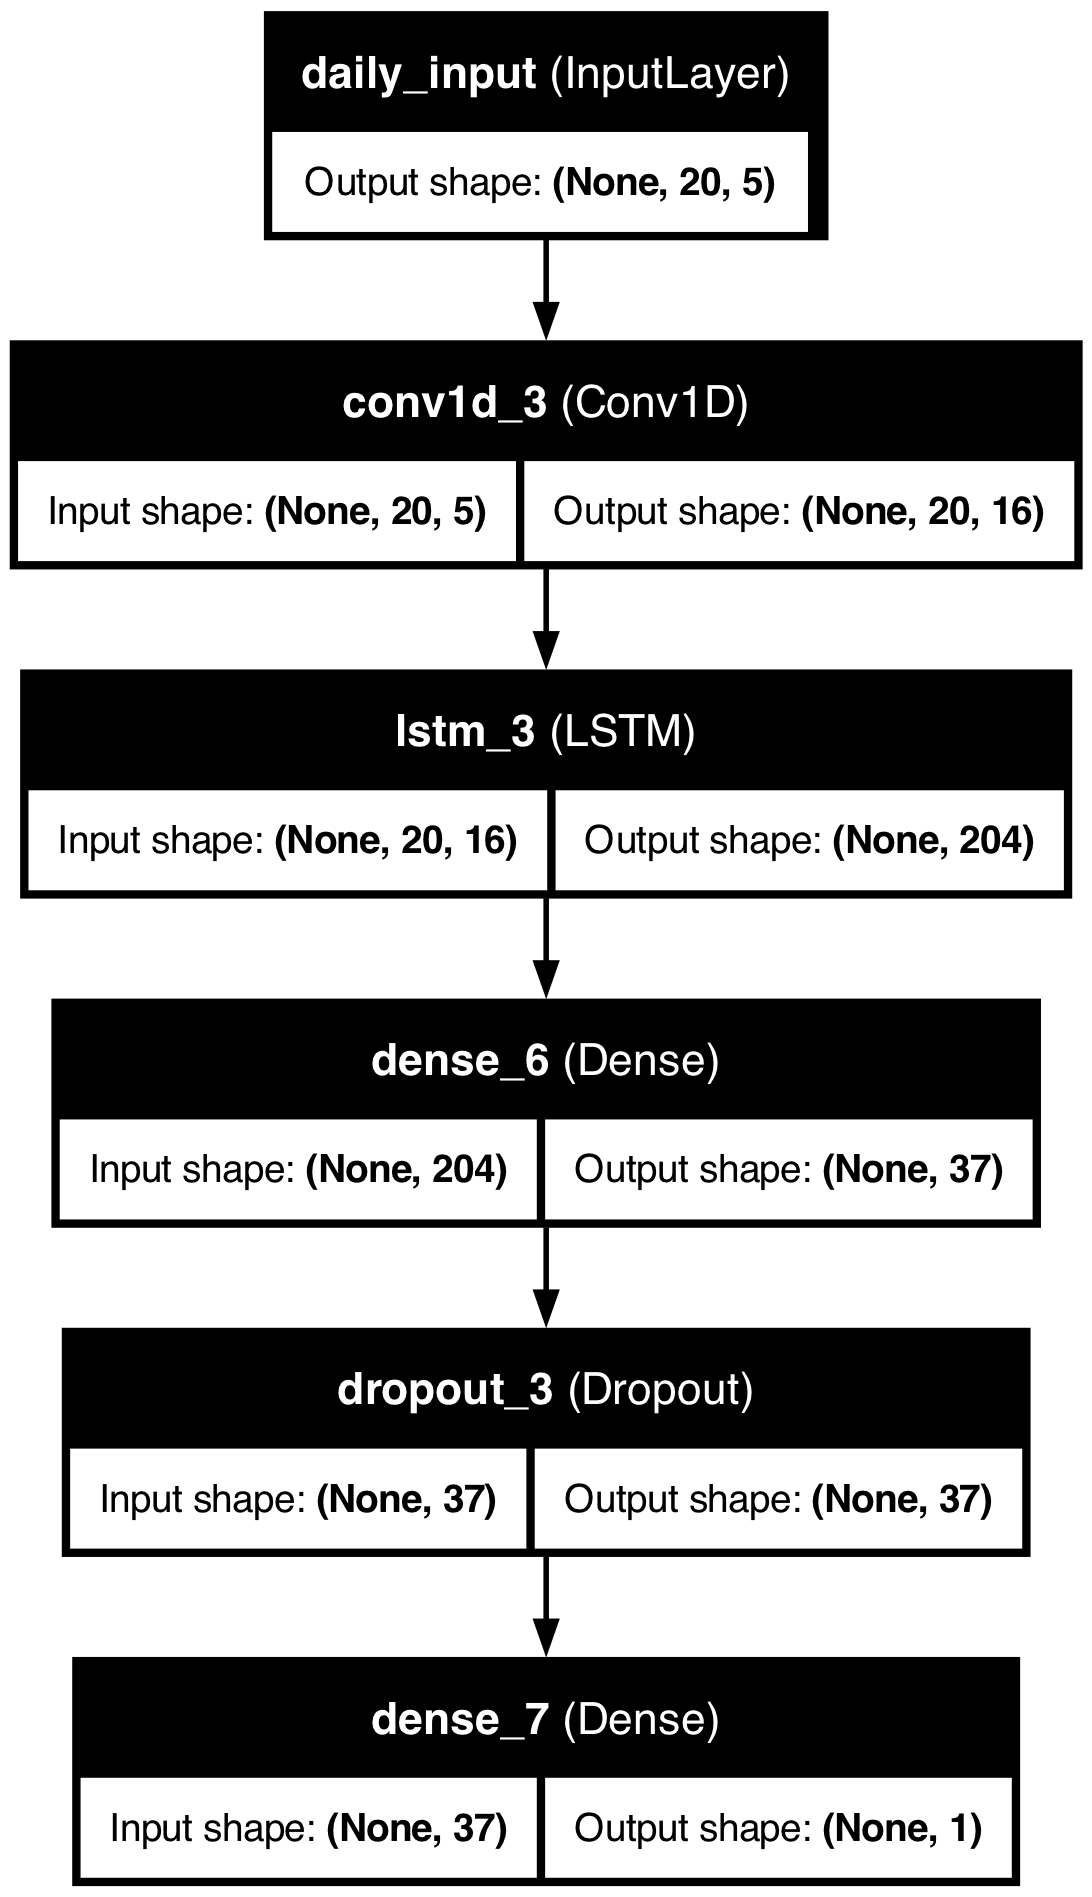

In [19]:
plot_model(final_model, to_file='model_structure.png', show_shapes=True, show_layer_names=True)

In [20]:

history = final_model.fit(x=daily_train_prepared,y=target_train_prepared,
                          batch_size=batch_size,validation_split=0.25,epochs=epochs,callbacks=[early_stopping])


Epoch 1/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - acc: 0.5042 - loss: 0.6999 - val_acc: 0.4967 - val_loss: 0.6983
Epoch 2/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - acc: 0.5627 - loss: 0.6872 - val_acc: 0.4967 - val_loss: 0.7012
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - acc: 0.5435 - loss: 0.6860 - val_acc: 0.4967 - val_loss: 0.6993
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - acc: 0.5451 - loss: 0.6870 - val_acc: 0.4967 - val_loss: 0.6991
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - acc: 0.5461 - loss: 0.6911 - val_acc: 0.4967 - val_loss: 0.7006
Epoch 6/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - acc: 0.5464 - loss: 0.6889 - val_acc: 0.4967 - val_loss: 0.7068
Epoch 7/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - acc: 0.5745 - loss: 0.6846 - val_acc: 0.4967 - val_loss: 0.7209
Epoch 8/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - acc: 0.5443 - loss: 0.6915 - val_acc: 0.4967 - val_loss: 0.6997
Epoch 9/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - ac

## 7.5 model.evaluate(输入测试数据)，进行模型预测性能测试

In [23]:
loss,accuracy = final_model.evaluate(daily_test_prepared,y=target_test_prepared)
print(loss,accuracy)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc: 0.4713 - loss: 0.6980
0.6954291462898254 0.49659863114356995


# 8. 回测

# 构建y的函数

In [26]:
def gen_y_pred():
    y_predict=final_model.predict(daily_test_prepared,batch_size=1).reshape(test_num-daily_back).tolist() ###batch_size要设为1，不然evaluate和predict结果不同
    y_pred=[]
    for i,v in enumerate(y_predict):
        if v>0.5:
            y_pred.append(1)
        if v<0.5:
            y_pred.append(0)
    return y_pred

# 制作y

In [27]:
y_pred=gen_y_pred()
print(y_pred)

441/441 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

#  构建使用测试集作为回测数据的类

In [34]:
class Back_tes_trader:
    def __init__(self,train_num,daily_back):
        self.train_num=train_num
        self.daily_back=daily_back
        
    def daily_test_data(self,data):
        while True:
            samples = data.loc[
                data.index >=self.train_num+self.daily_back ,
                ['open','close']]
            print(data.index)
            return samples
        


# 回测数据集代入参数，形成回撤数据back_tes_trader

In [29]:
back_tes_trader=Back_tes_trader(train_num=train_num,daily_back=20)

In [30]:
def split_back_trader(train_num=train_num):

    daily_test_df=daily_df.loc[daily_df.index>=train_num]

    return {'daily_test_df':daily_test_df}

In [31]:
back_df=split_back_trader()['daily_test_df']

In [32]:
back_df

,trade_time,open,high,low,close,volume_rate,search_index,sector_score
1846,2023-08-22,3103.78,3126.78,3074.53,3120.33,309316335,266781.0,-0.848946
1847,2023-08-23,3116.27,3116.38,3077.61,3078.40,272244124,265647.0,-0.929211
1848,2023-08-24,3085.91,3106.18,3072.95,3082.24,300024637,254384.0,-1.115758
1849,2023-08-25,3068.62,3085.05,3053.04,3064.07,293347686,256344.0,-1.022822
1850,2023-08-28,3219.04,3219.04,3089.12,3098.64,485607764,473517.0,-1.058155
...,...,...,...,...,...,...,...,...
2302,2025-07-14,3513.25,3532.12,3513.25,3519.65,572084705,NaN,NaN
2303,2025-07-15,3519.81,3527.04,3483.38,3505.00,572074726,NaN,NaN
2304,2025-07-16,3502.90,3511.81,3489.14,3503.78,470878578,NaN,NaN
2305,2025-07-17,3500.37,3517.28,3499.19,3516.83,472211056,NaN,NaN


In [36]:
backtrader_df=back_tes_trader.daily_test_data(back_df)

Index([1846, 1847, 1848, 1849, 1850, 1851, 1852, 1853, 1854, 1855,
       ...
       2297, 2298, 2299, 2300, 2301, 2302, 2303, 2304, 2305, 2306],
      dtype='int64', length=461)


# 形成day_rate_of_return日内收益率，和rate_of_return隔夜收益率

In [37]:
# 计算收益率
backtrader_df['rate_of_return'] = backtrader_df['close'].rolling(2).apply(lambda x: x[1] / x[0] - 1, raw=True)
backtrader_df['day_rate_of_return'] = backtrader_df['close'] / backtrader_df['open'] - 1

# 将前一天的收盘价作为last_close，这样长度会自动匹配
backtrader_df['last_close'] = backtrader_df['close'].shift(1)

# 只保留需要的部分（根据你的train_num和daily_back条件）
start_idx = train_num + daily_back + 1
backtrader_df.loc[backtrader_df.index < start_idx, 'last_close'] = None

# 计算卖出收益率
backtrader_df['sale_rate_of_return'] = backtrader_df['open'] / backtrader_df['last_close'] - 1

print(backtrader_df)
print(backtrader_df.shape)
trade_day_return_list = []
return_multiple_list = []
every_day_return_list = []

         open    close  rate_of_return  day_rate_of_return  last_close  \
1866  3123.99  3124.96             NaN            0.000311         NaN   
1867  3118.67  3108.57       -0.005245           -0.003239     3124.96   
1868  3103.18  3084.70       -0.007679           -0.005955     3108.57   
1869  3084.76  3132.43        0.015473            0.015453     3084.70   
1870  3131.21  3115.61       -0.005370           -0.004982     3132.43   
...       ...      ...             ...                 ...         ...   
2302  3513.25  3519.65        0.002698            0.001822     3510.18   
2303  3519.81  3505.00       -0.004162           -0.004208     3519.65   
2304  3502.90  3503.78       -0.000348            0.000251     3505.00   
2305  3500.37  3516.83        0.003725            0.004702     3503.78   
2306  3519.48  3534.48        0.005019            0.004262     3516.83   

      sale_rate_of_return  
1866                  NaN  
1867            -0.002013  
1868            -0.001734  

# 回测交易逻辑

In [38]:
def backtrader(list,df):
    a=0

    return_multiple = 1
    for i,v in enumerate(list):
        if (v ==1)&(a==0):
            b=(1 + df.loc[train_num+daily_back + i, 'day_rate_of_return'])
            return_multiple= return_multiple * b
            a=1
            trade_day_return_list.append(b-1)
            return_multiple_list.append(return_multiple)
            every_day_return_list.append(b - 1)

        elif (v ==1)&(a==1):
            b=(1 + df.loc[train_num+daily_back + i, 'rate_of_return'])
            return_multiple= return_multiple *b
            a=a
            trade_day_return_list.append(b-1)
            return_multiple_list.append(return_multiple)
            every_day_return_list.append(b - 1)
        elif (v==0)&(a==1):
            a=0
            b = (1 + df.loc[train_num+daily_back + i, 'sale_rate_of_return'])
            return_multiple=return_multiple*b
            trade_day_return_list.append(b-1)
            every_day_return_list.append(b - 1)
            return_multiple_list.append(return_multiple)
        elif (v==0)&(a==0):
            return_multiple=return_multiple
            a=a
            every_day_return_list.append(0)


    return a,trade_day_return_list,return_multiple,return_multiple_list,every_day_return_list

In [39]:
result=backtrader(y_pred,backtrader_df)

pingjun_nian_jiaoyi_ri=240*len(result[1])/(len(y_pred))
sharp=(np.mean(result[1]))/(np.std(result[1],ddof=1))*np.sqrt(pingjun_nian_jiaoyi_ri)

print('夏普比率：',sharp)
print('收益率：',result[2]-1)


夏普比率： 0.8084209574106618
收益率： 0.22102495525039378


In [40]:
every_day_return_list=result=backtrader(y_pred,backtrader_df)[4]

In [41]:
# 基于完整每日收益计算（推荐）
daily_factors = pd.Series(every_day_return_list) + 1  # 包含空仓日（空仓日为1.0）
cumulative_factors = daily_factors.cumprod()  # 完整累计收益倍数
rolling_max_factors = cumulative_factors.cummax()
drawdown_returns = (cumulative_factors - rolling_max_factors) / rolling_max_factors
max_drawdown = drawdown_returns.min()
print("最大回撤:", max_drawdown)

最大回撤: -0.13631400223873638


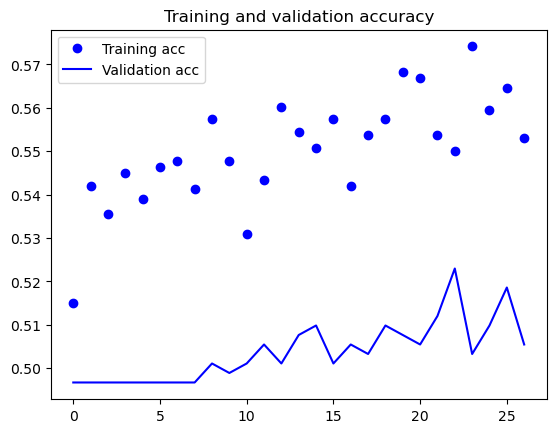

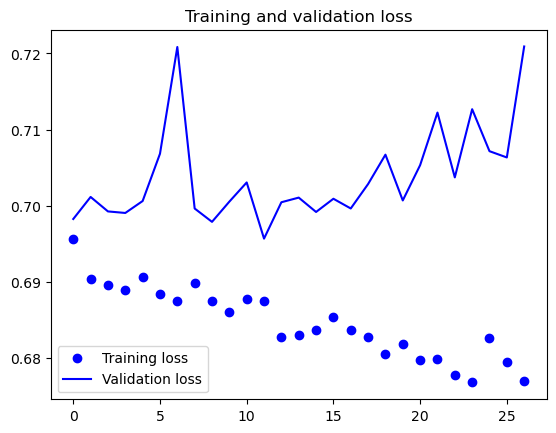

In [42]:
def paint():
    acc=history.history['acc']
    val_acc=history.history['val_acc']
    loss=history.history['loss']
    val_loss=history.history['val_loss']

    epochs=range(len(acc))
    plt.plot(epochs,acc,'bo',label='Training acc')
    plt.plot(epochs,val_acc,'b',label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs,loss,'bo',label='Training loss')
    plt.plot(epochs,val_loss,'b',label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    return plt
my_paint=paint()
my_paint.show()

# 混淆矩阵绘制

In [44]:
confusion_matrix = confusion_matrix(target_test_prepared, y_pred,labels=[1,0])
precision_score=precision_score(target_test_prepared, y_pred)
recall_score=recall_score(target_test_prepared, y_pred)
f1_score=f1_score(target_test_prepared, y_pred)

print('混淆矩阵：',confusion_matrix)
print('查准率：',precision_score)
print('查全率：',recall_score)
print('f1-score:',f1_score)

混淆矩阵： [[152  71]
 [151  67]]
查准率： 0.5016501650165016
查全率： 0.6816143497757847
f1-score: 0.5779467680608364


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


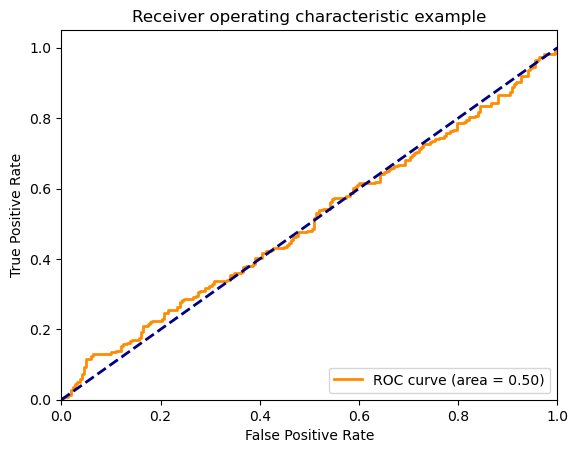

In [46]:
y_predict=final_model.predict(daily_test_prepared).reshape(test_num-daily_back).tolist()
fpr,tpr,threshold = roc_curve(target_test_prepared, y_predict) ###计算真正率和假正率
# print(fpr,tpr,threshold)
roc_auc = auc(fpr,tpr)


lw = 2
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率为横坐标，真正率为纵坐标做曲线
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()